In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
import os
import re

import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import decoupler as dc
import random
import sc_toolbox

from glob import glob
from scipy.sparse import csr_matrix, isspmatrix
from datetime import datetime
from collections import defaultdict

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

In [13]:
import sys
sys.path.append('..')

from src.configs import config
from src.utils import utils as us
from src.utils import functional_utils as fu
from src.utils import visualise as vs
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython
warnings.filterwarnings("once")
warnings.filterwarnings("ignore", category=FutureWarning)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [15]:
%%R
library(edgeR)
library(limma)
# library(MAST)

# Load Data

In [16]:
def index(data, name='Unnamed: 0'):
    data.index = pd.Index(data[name])
    data.drop([name], axis=1, inplace=True)
    return data

In [17]:
paths = glob(str(config.PATHS.LOGS/'w*_markers.csv'))
timeline = dict()

for path in paths:
    selected = index(pd.read_csv(path), 'names')
    selected.drop(['Unnamed: 0'], axis=1, inplace=True)
    week = int(re.findall(r'w([0-9]+).*', os.path.basename(path))[0])
    timeline[week] = selected

In [18]:
reactome = fu.load_GO()
collectri = fu.load_collectri()

Initialising MSigDB reactome...


# Launch

1
Launched GSEA


/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Launched ULM for TF slope t-stat
Launched ORA
2
Launched GSEA


/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


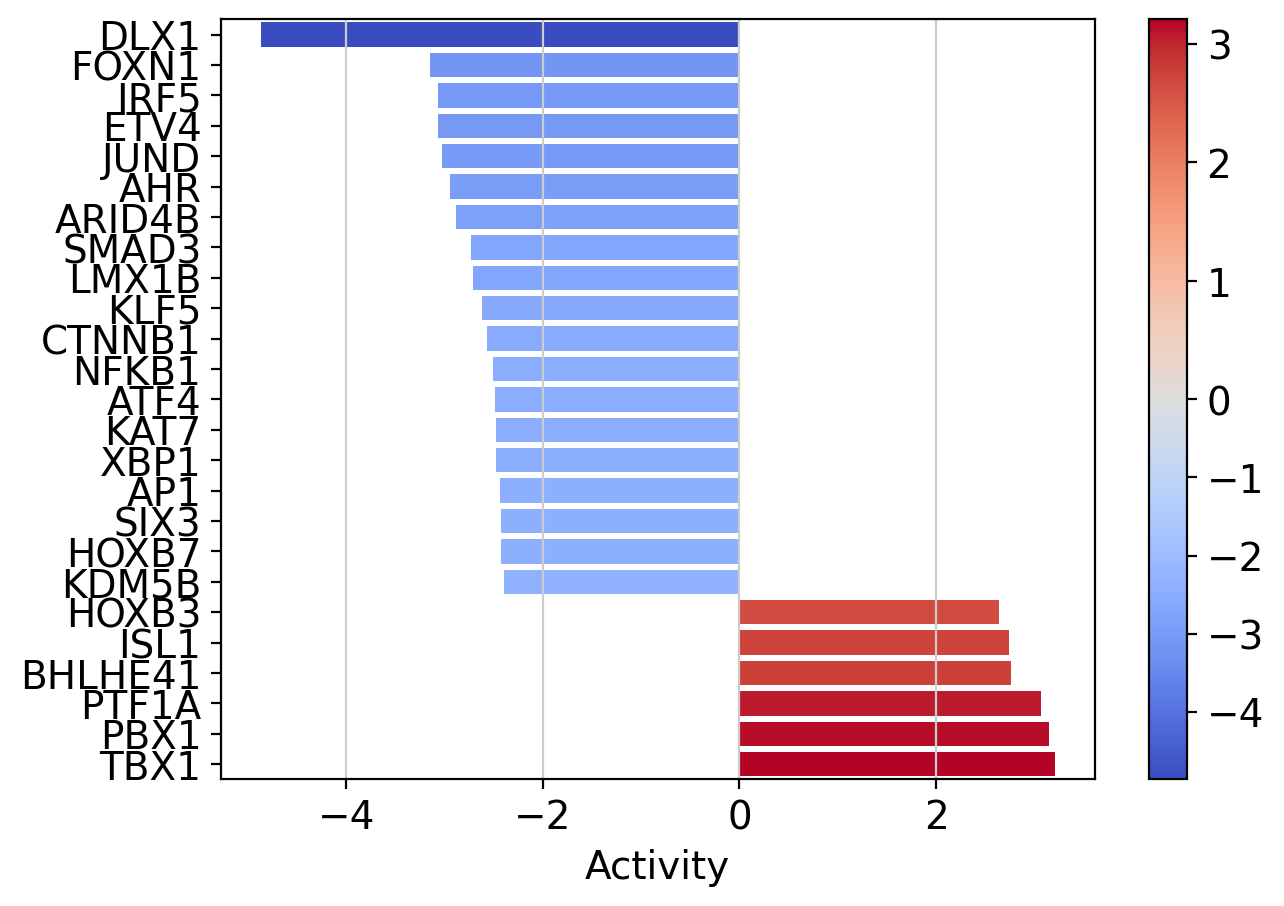

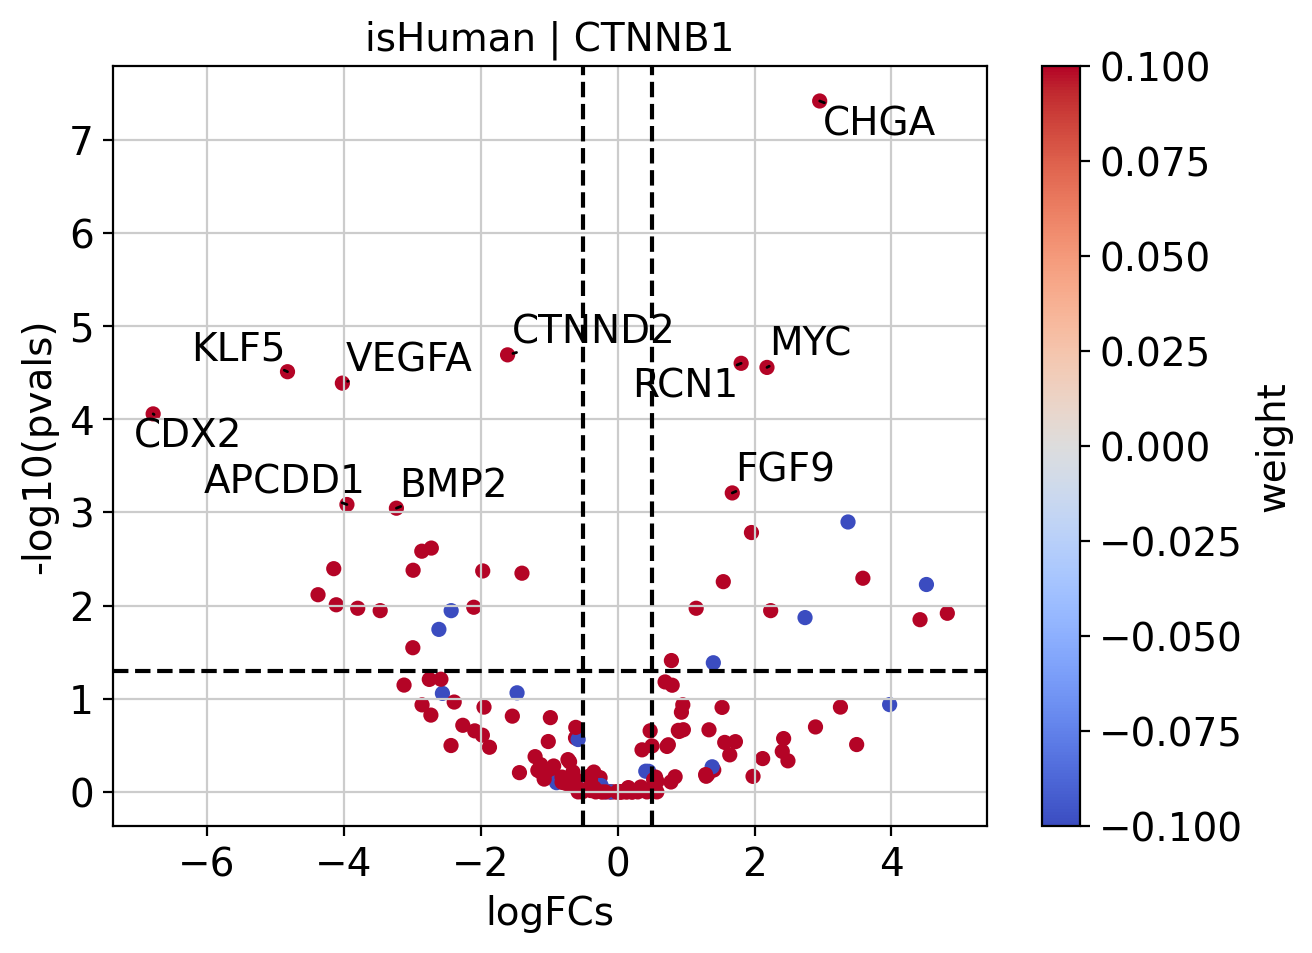

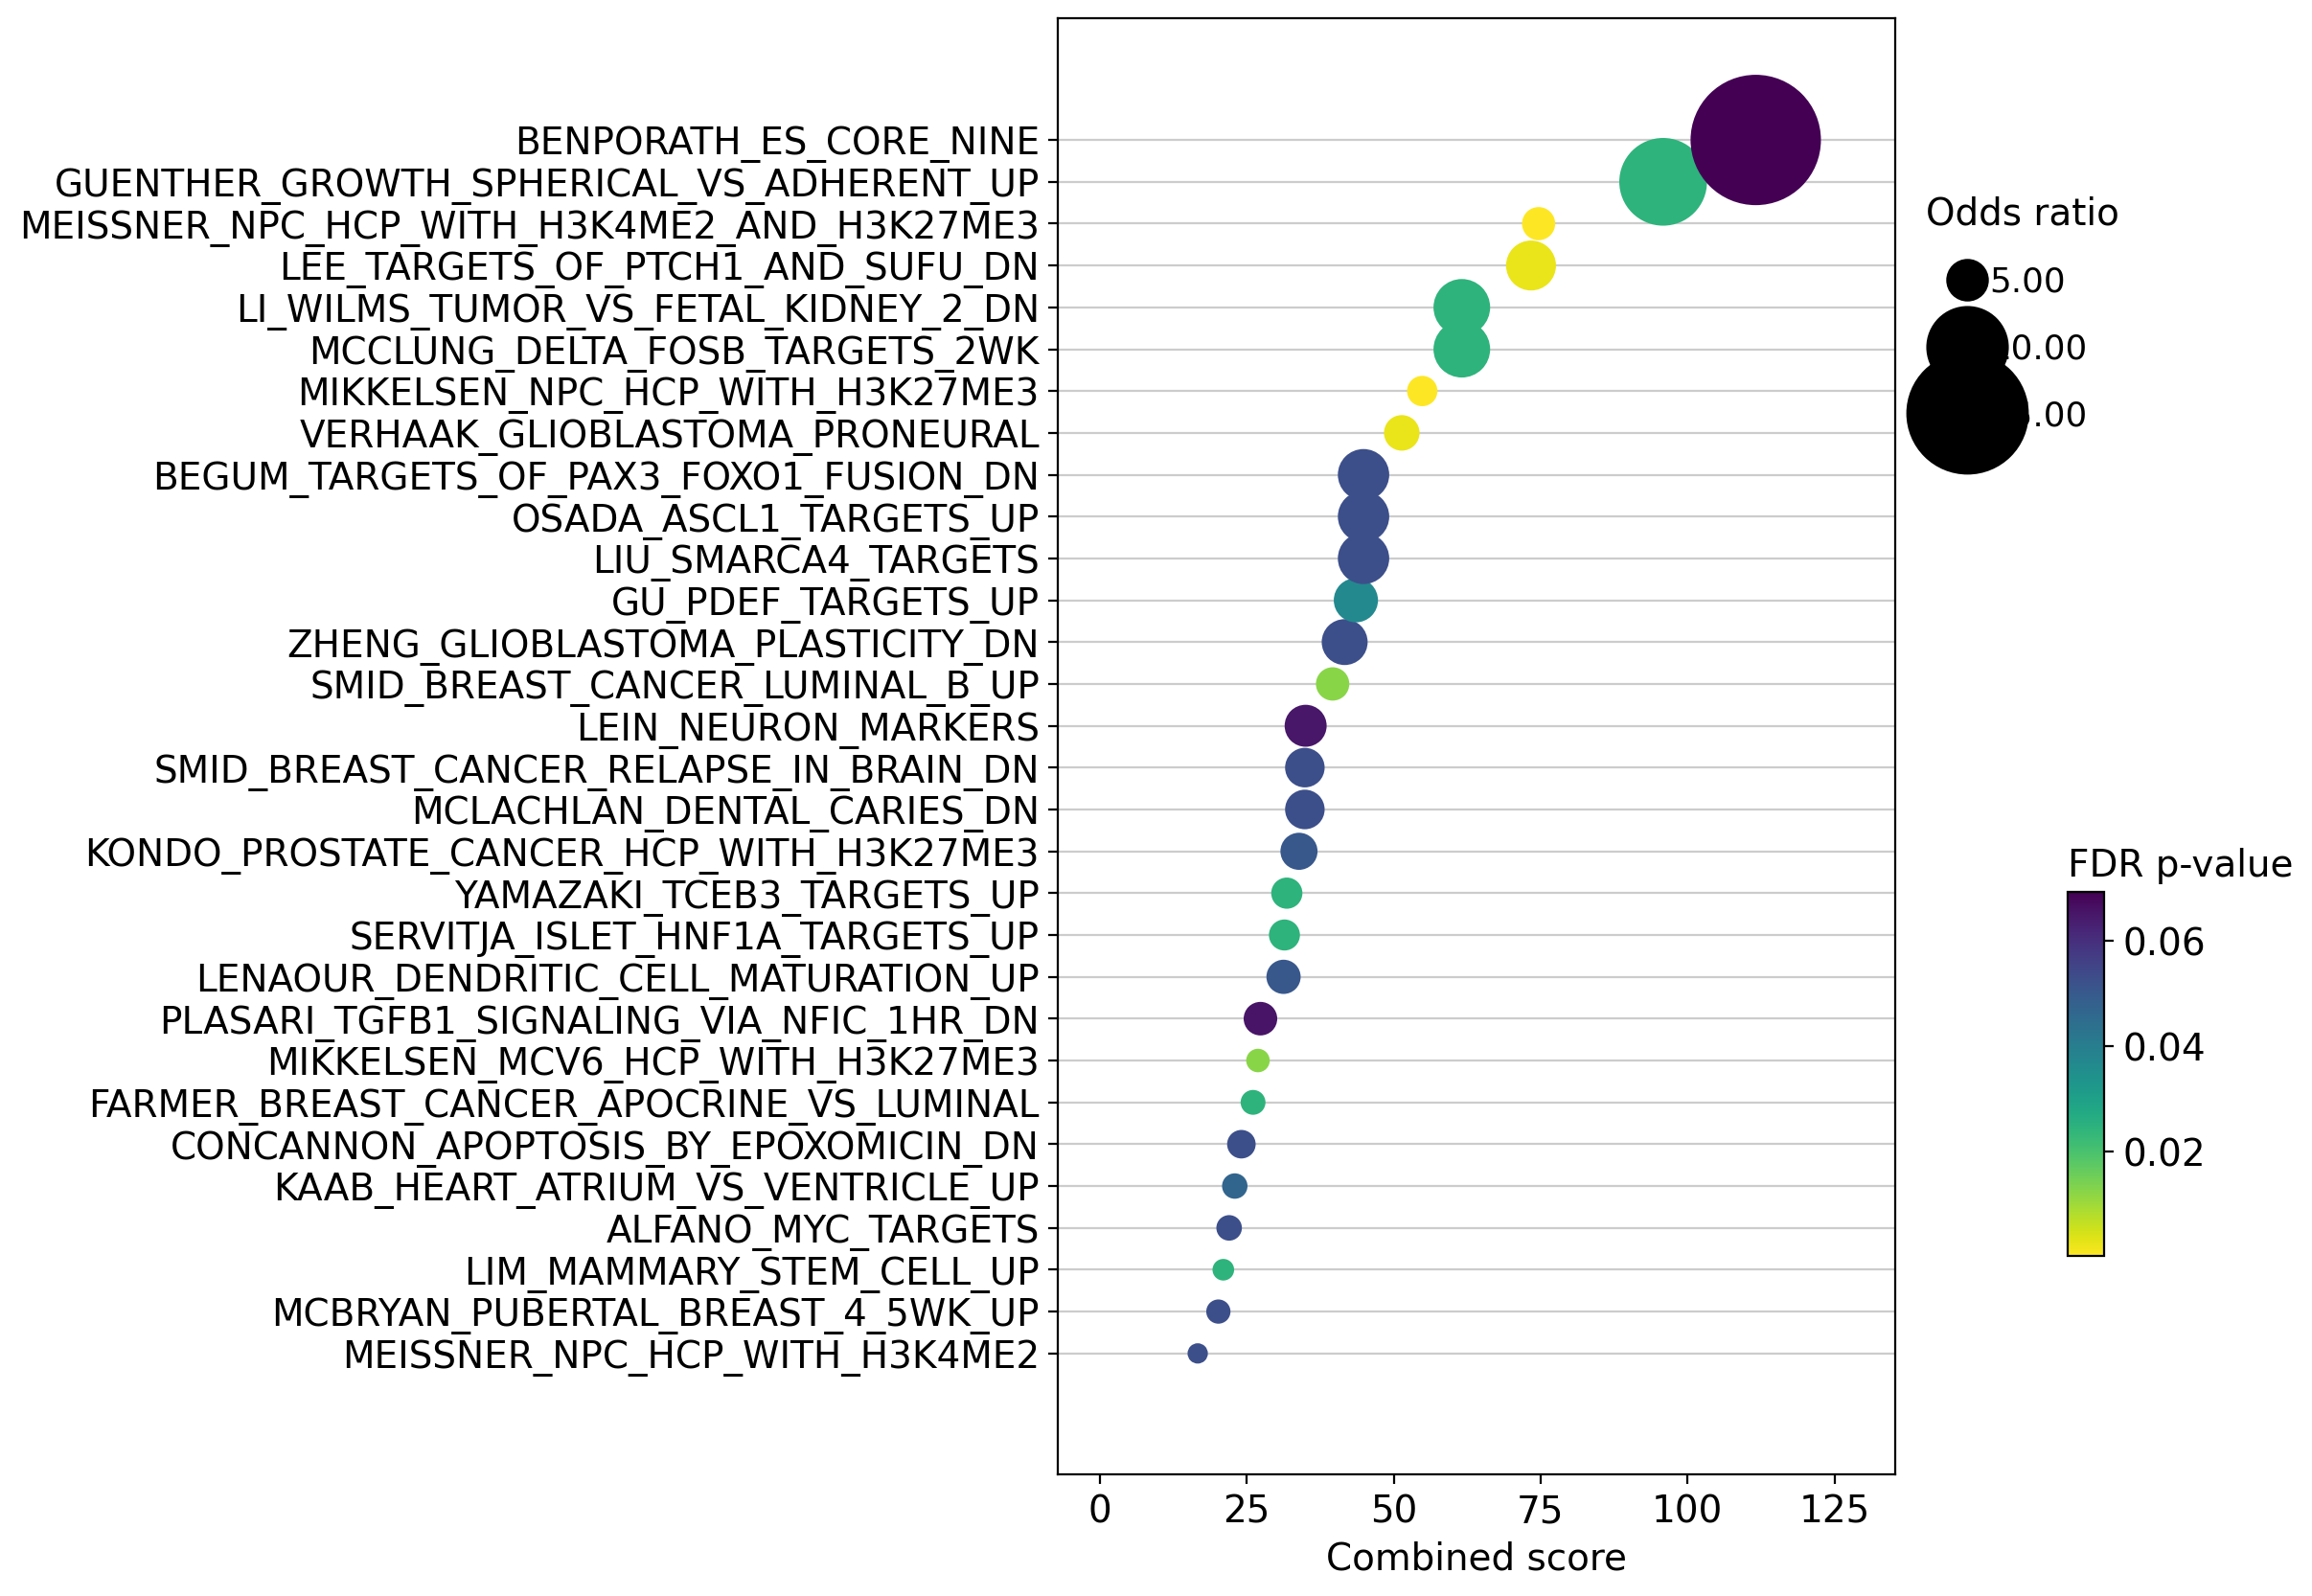

Launched ULM for TF slope t-stat
Launched ORA
4
Launched GSEA


/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


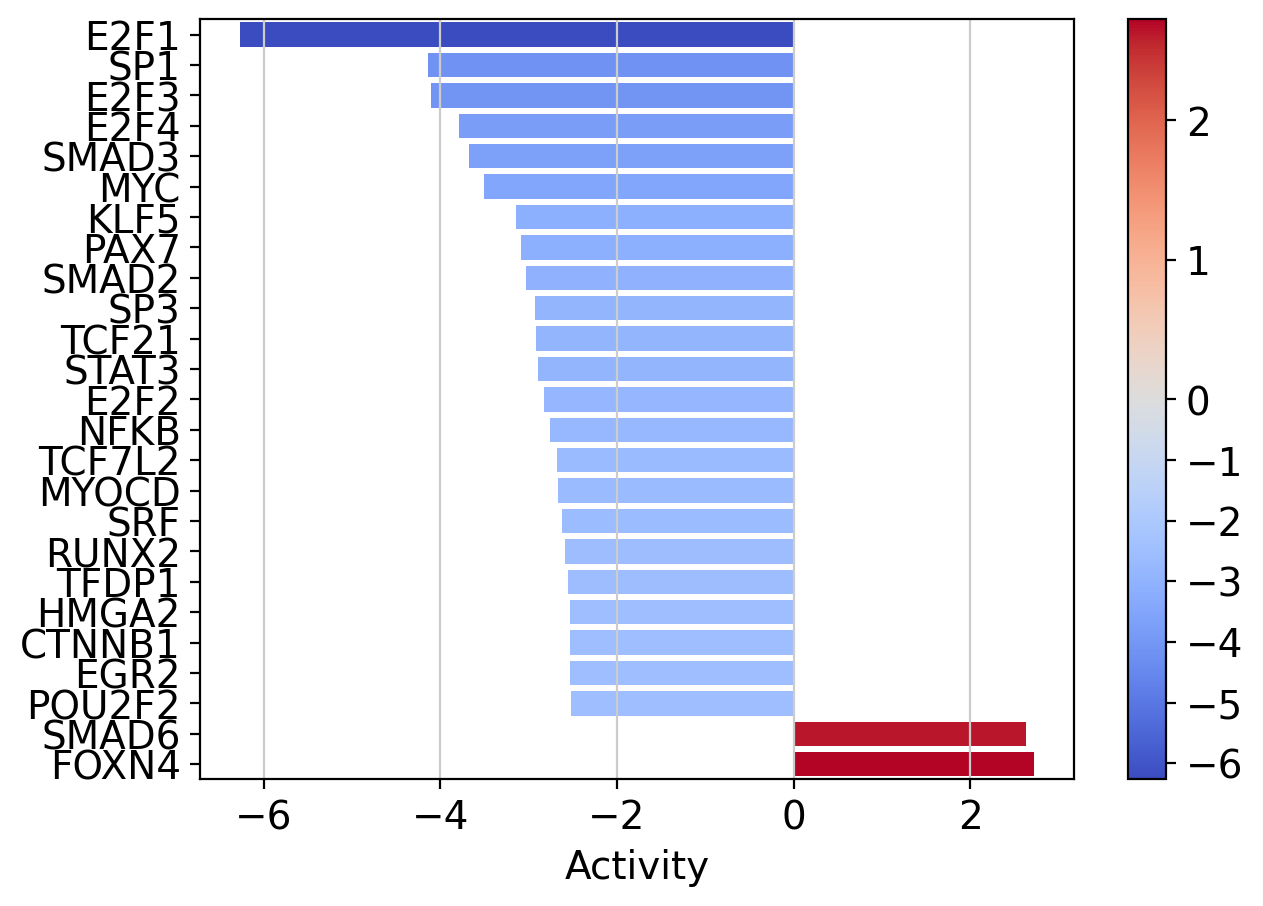

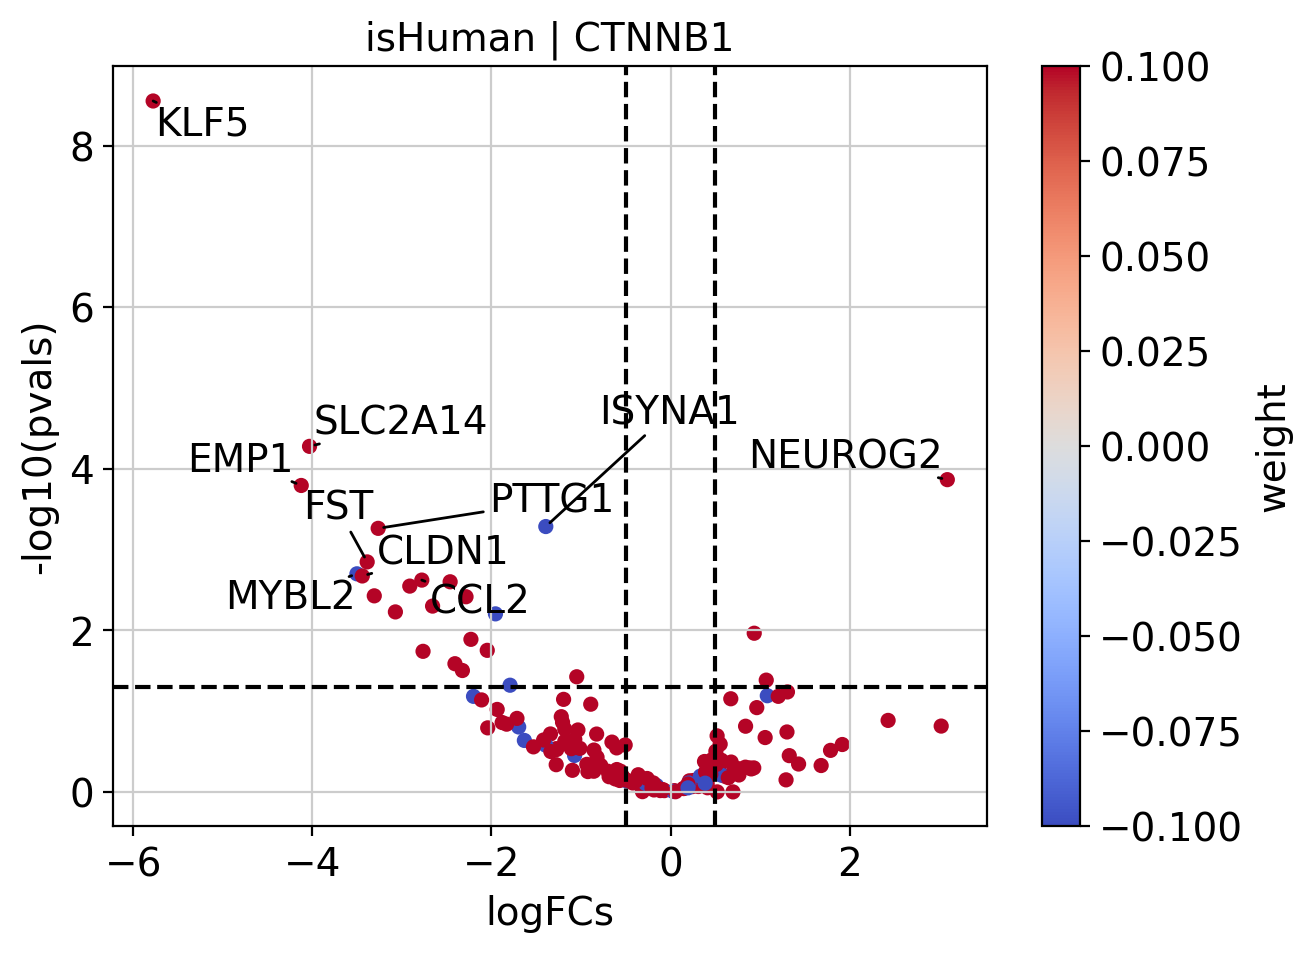

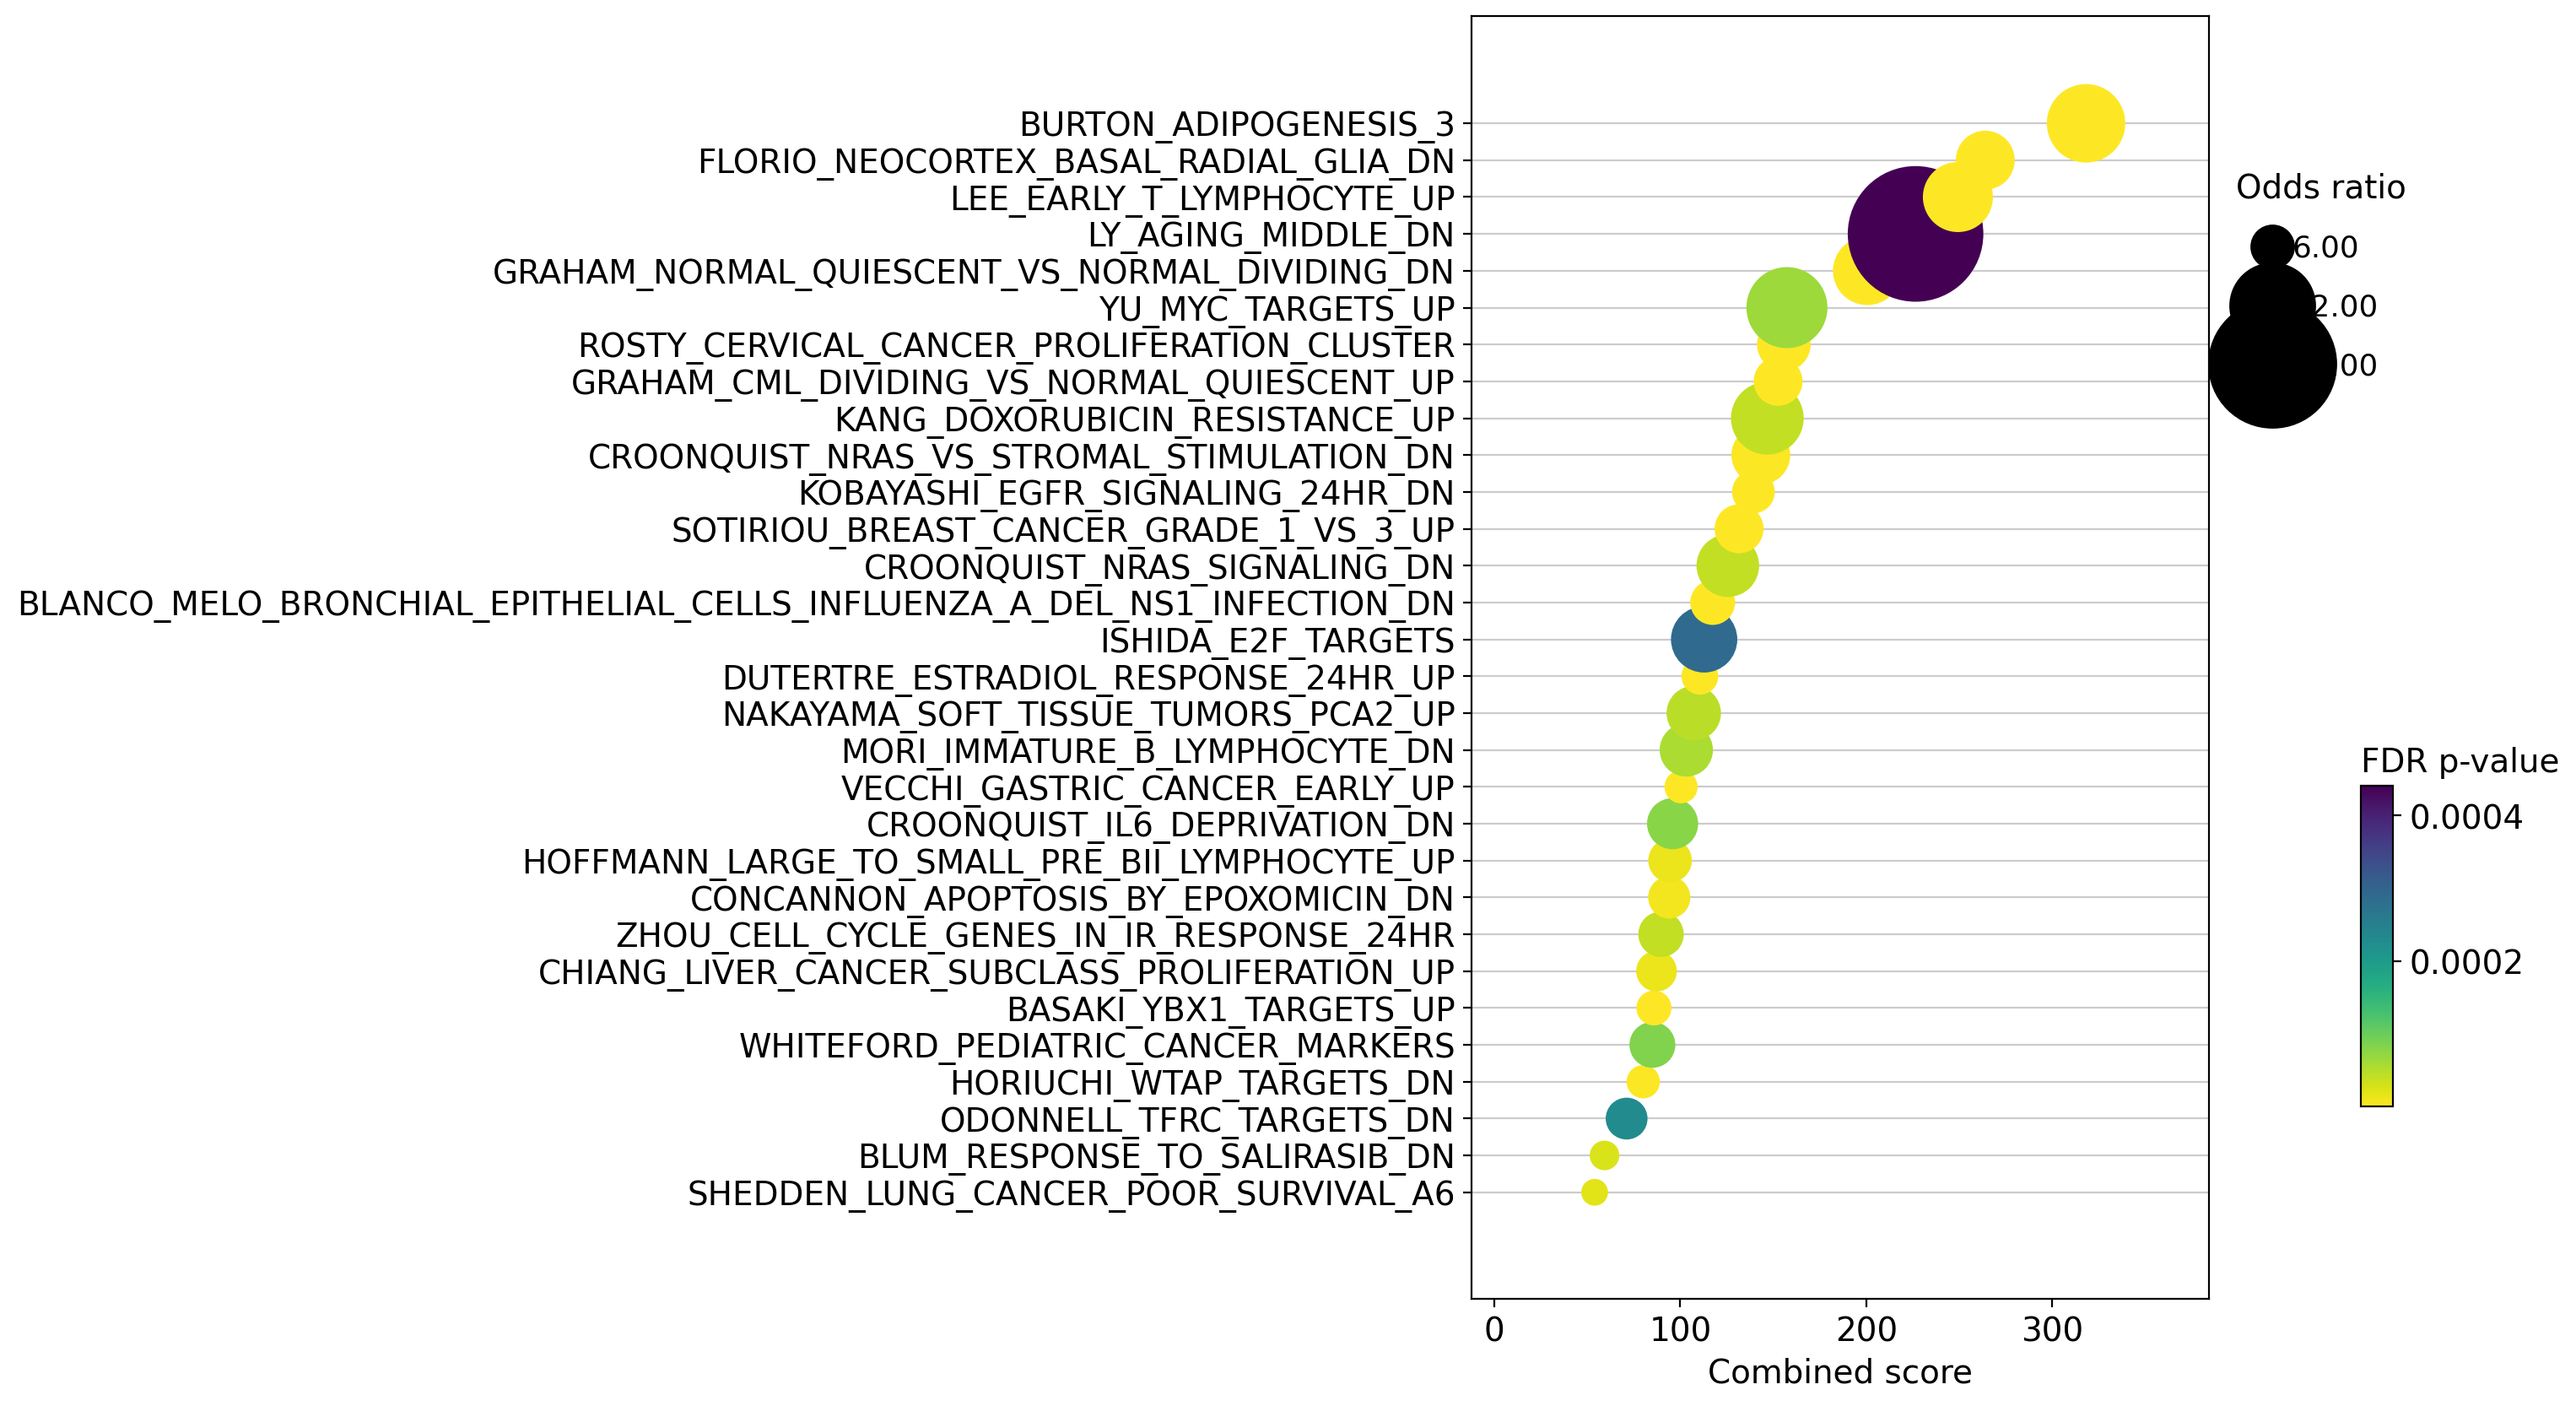

Launched ULM for TF slope t-stat
Launched ORA
5
Launched GSEA


/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


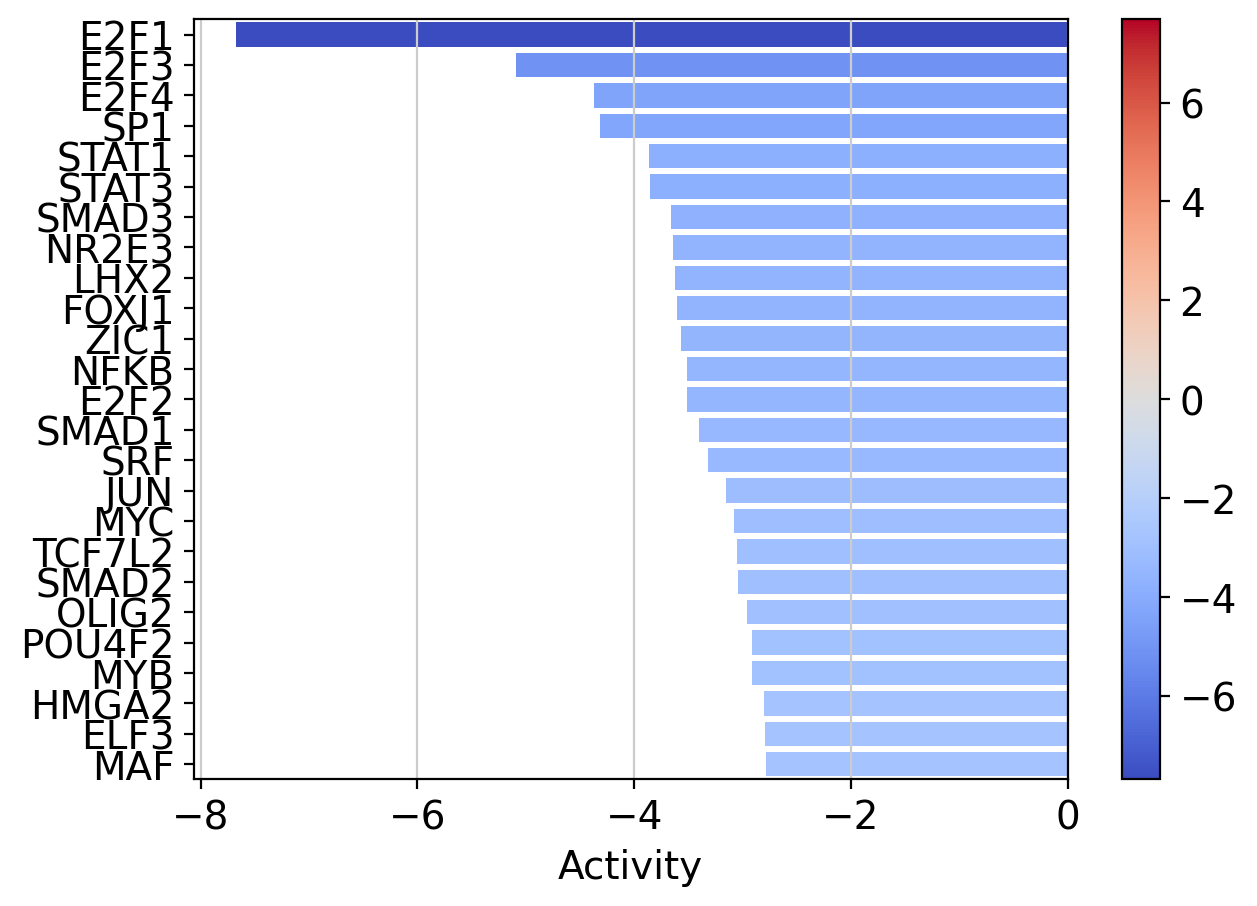

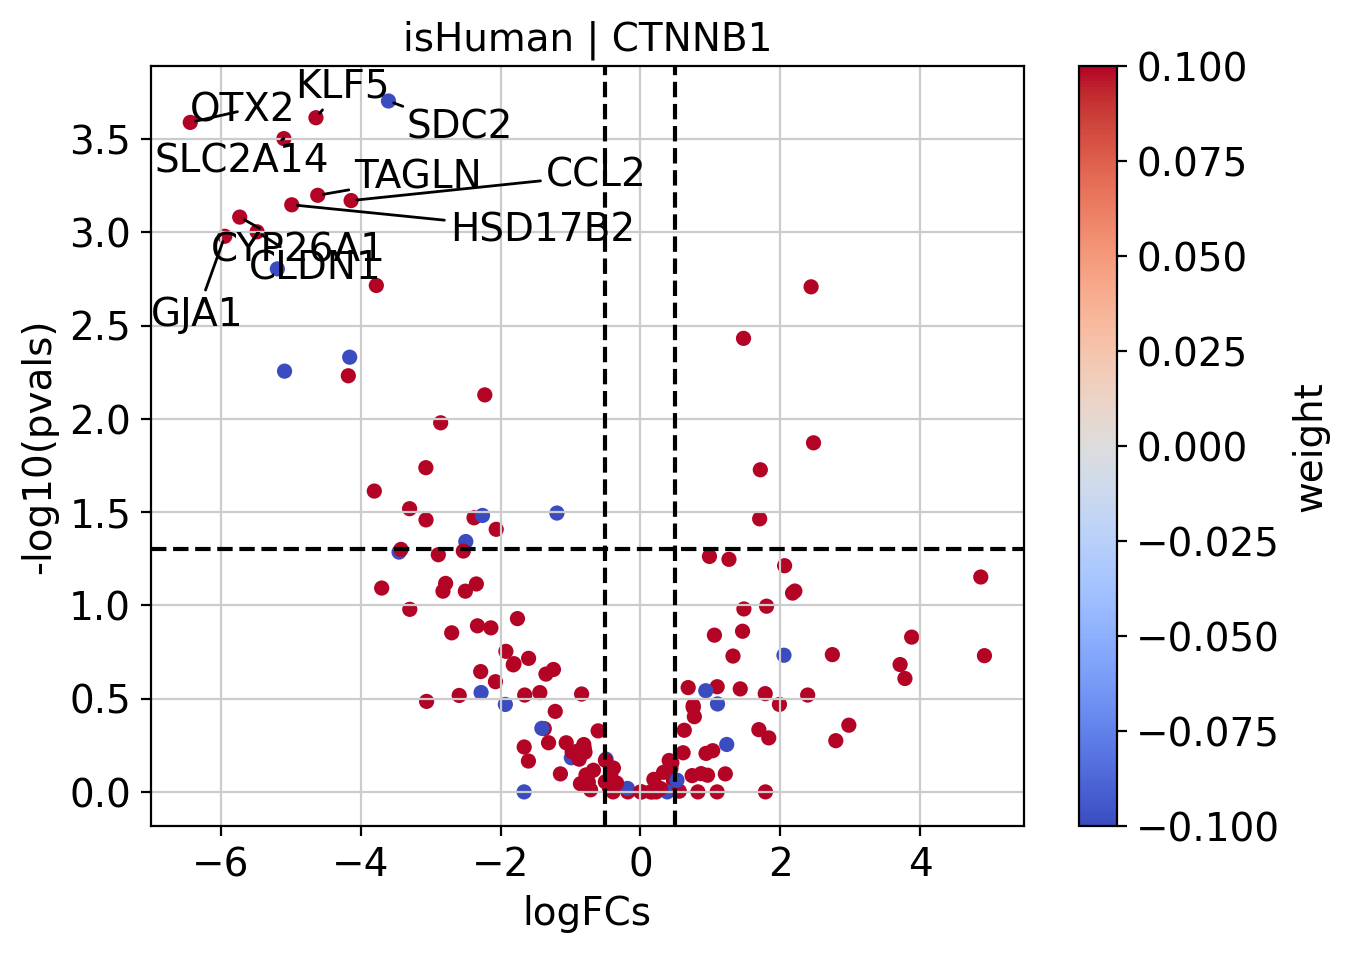

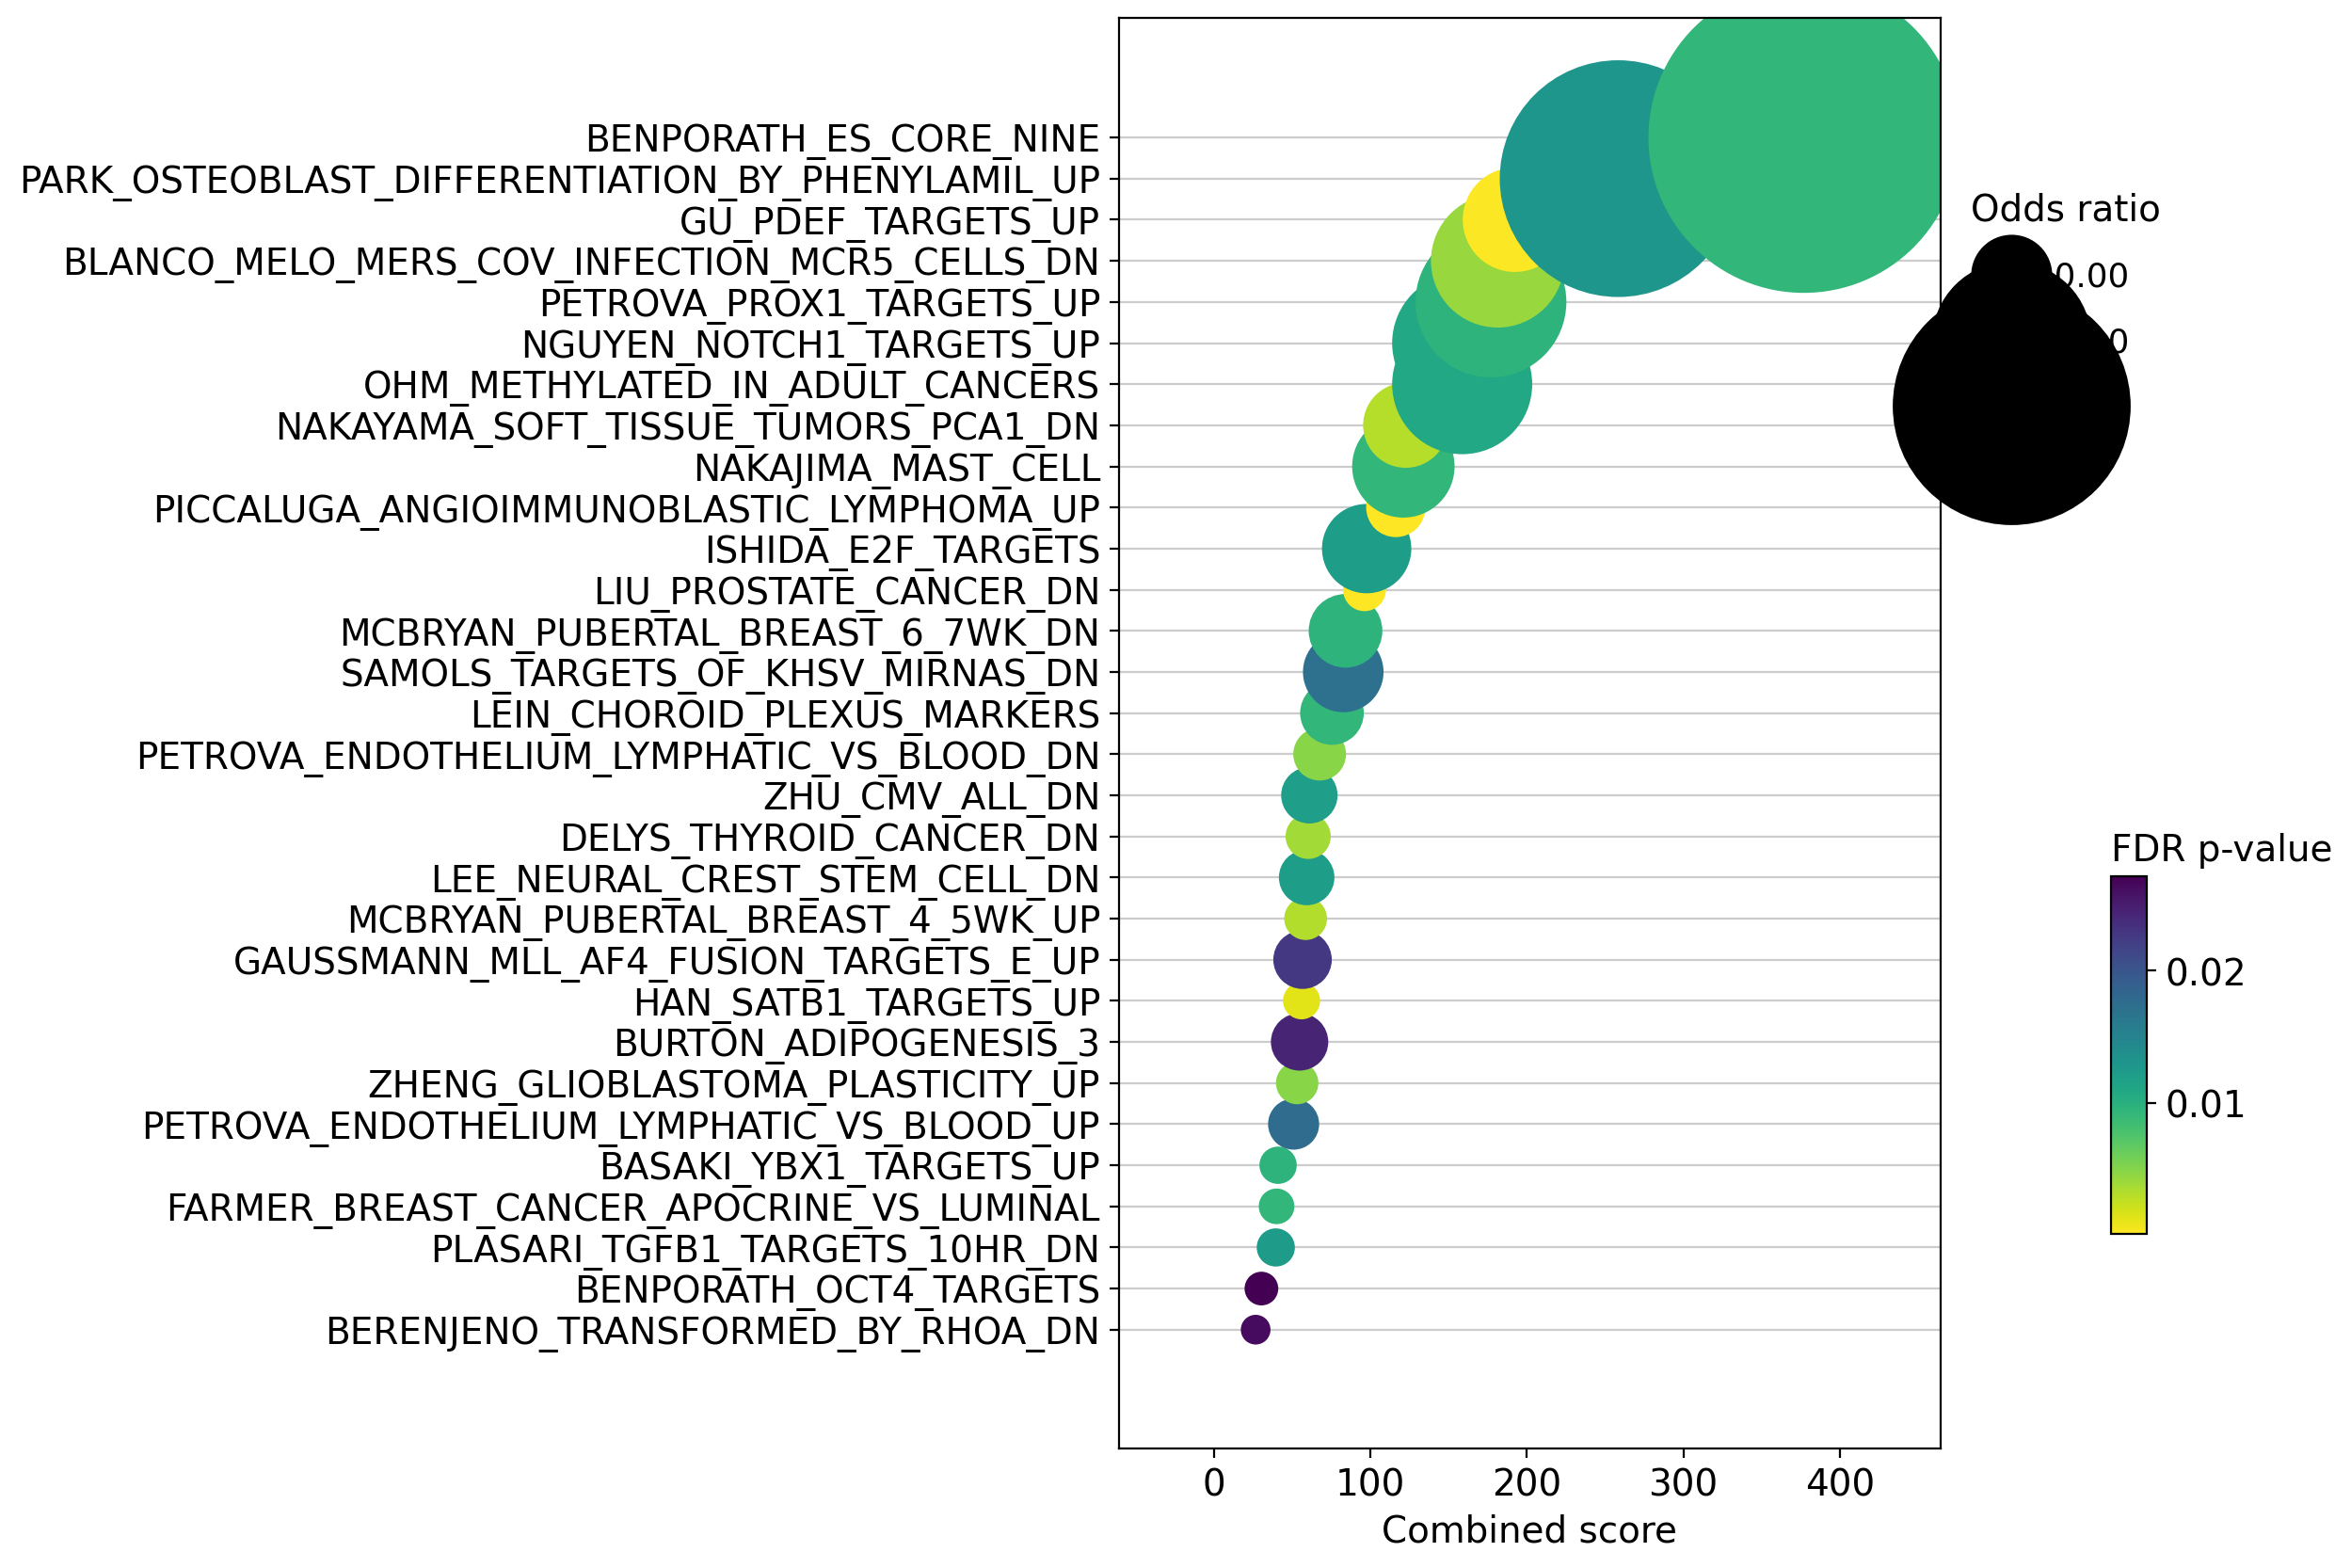

Launched ULM for TF slope t-stat
Launched ORA


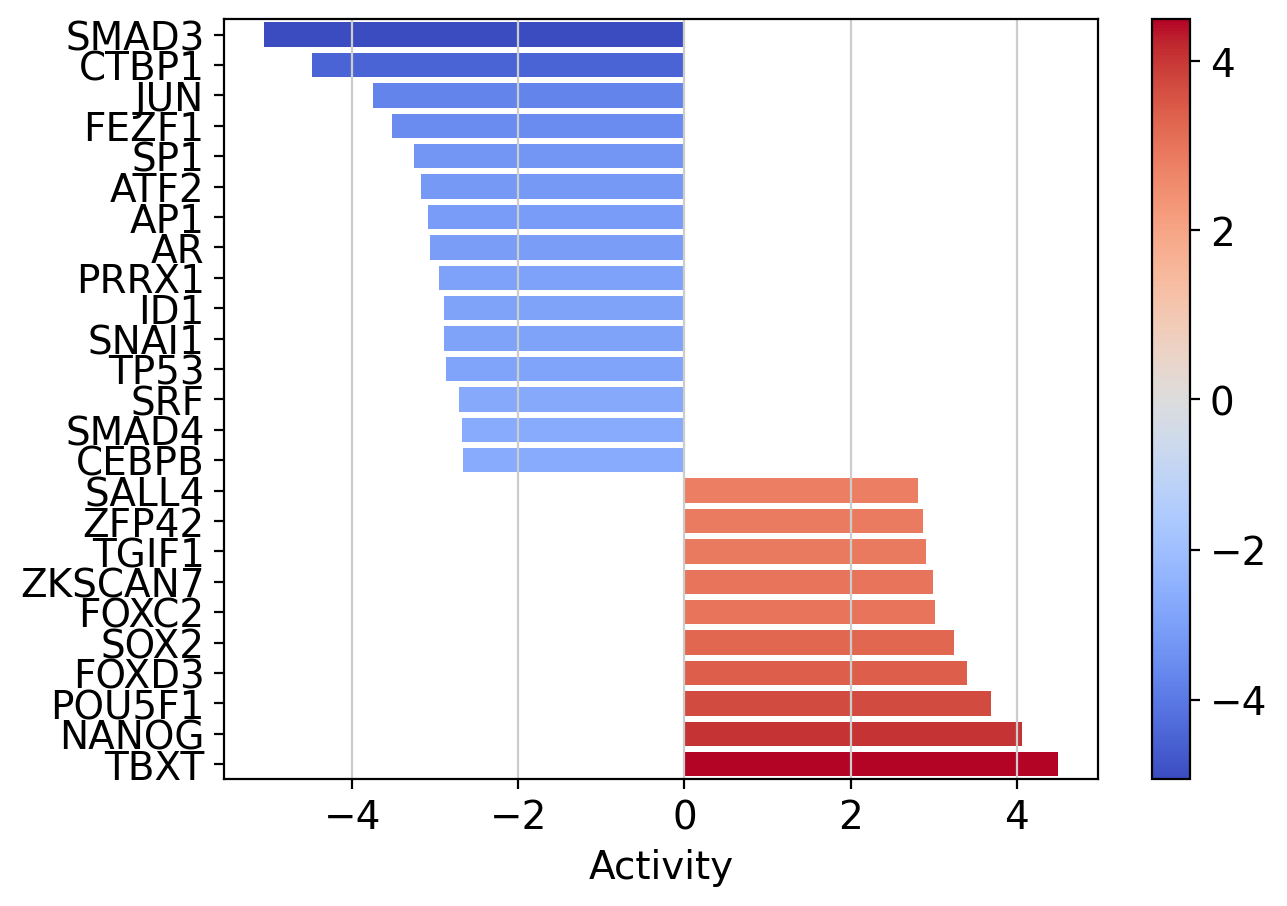

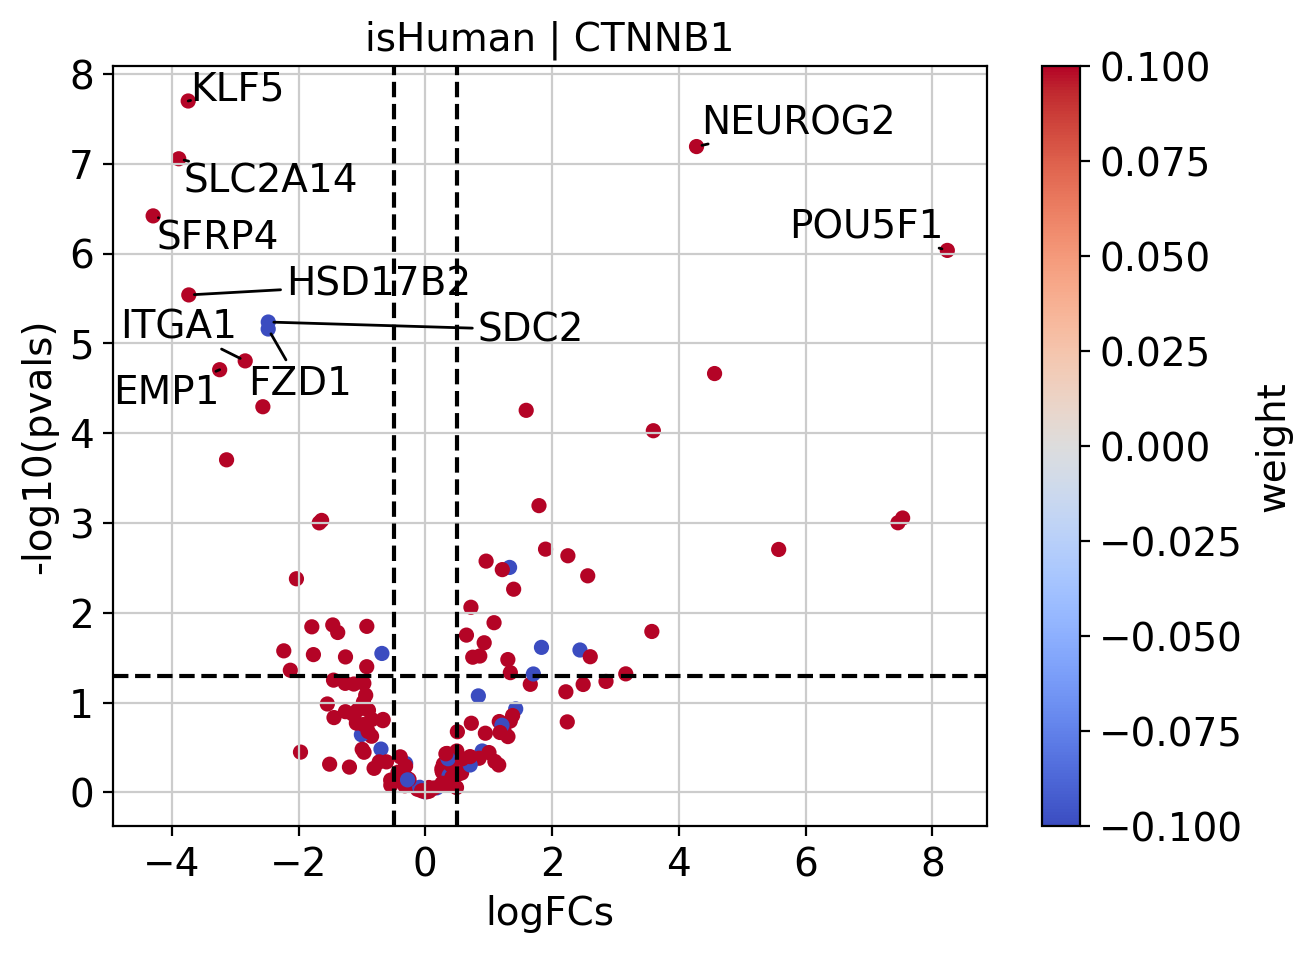

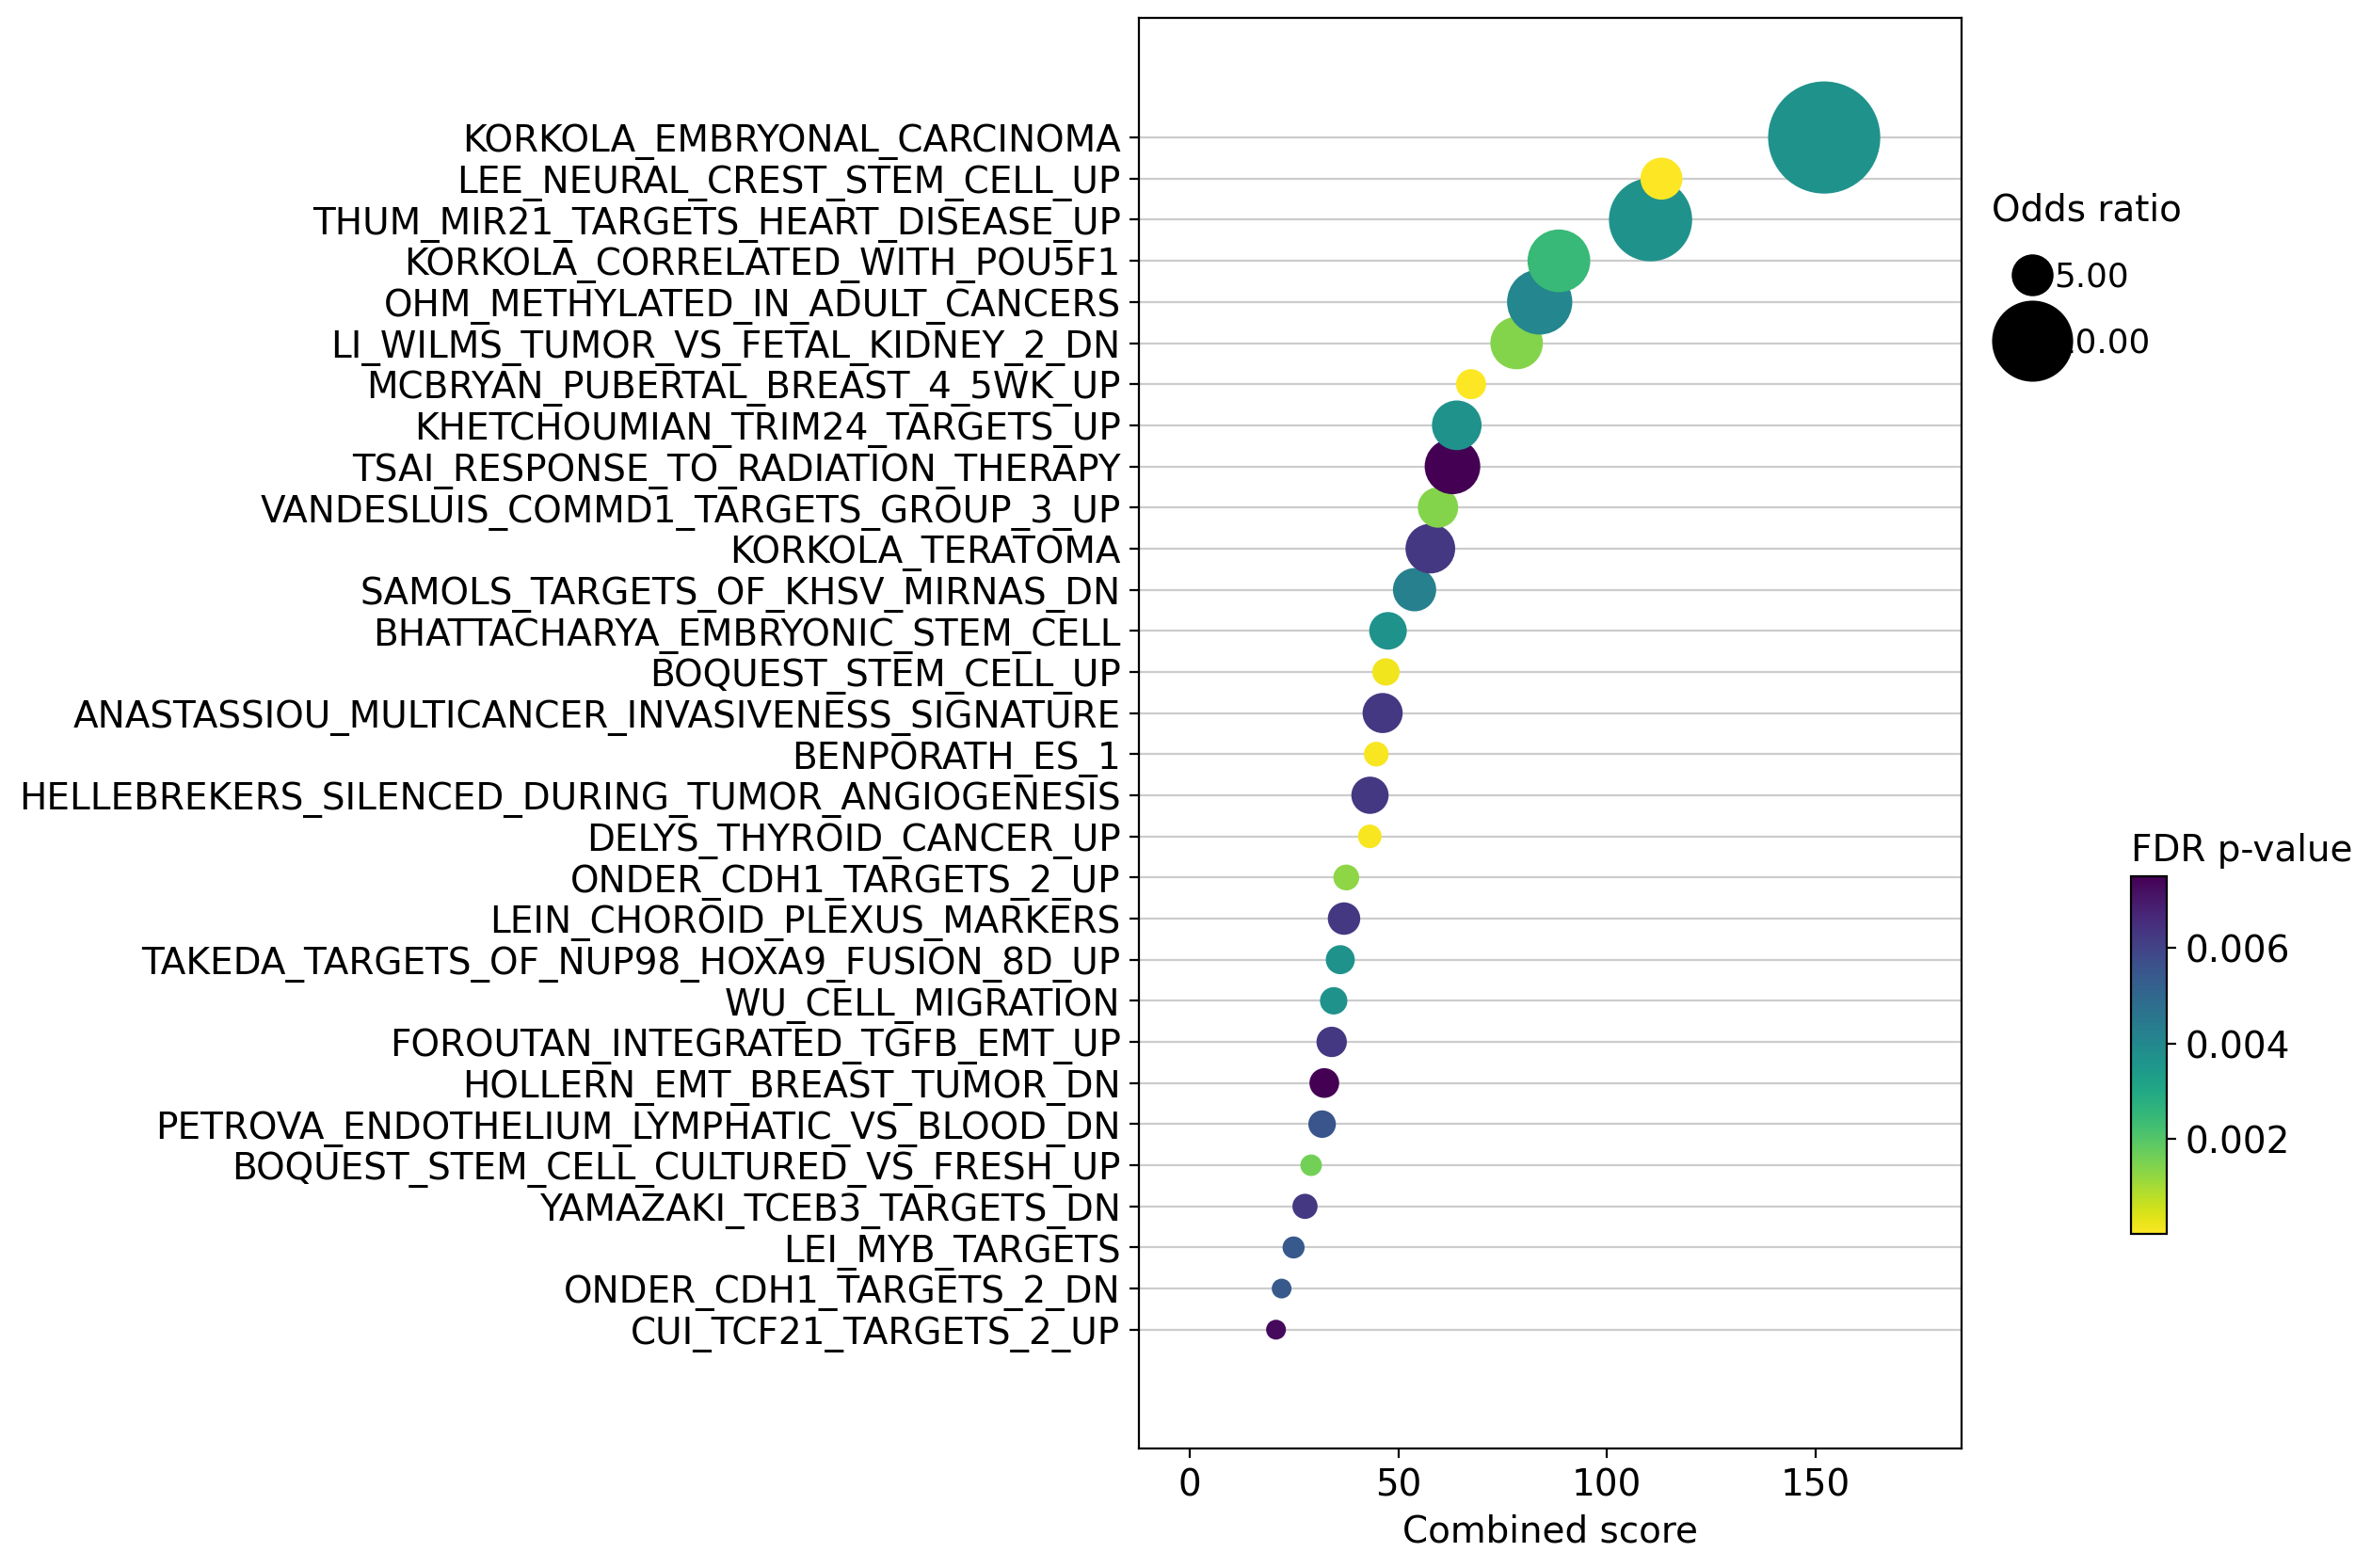

In [9]:
results = defaultdict(dict)
for week, selected in timeline.items():
    wait(1)
    print(week)
    results[week]['gsea_results'] = fu.run_GSEA(selected, reactome)
    results[week]['ulm'] = fu.run_ULM(selected, collectri)
    results[week]['ora_results'] = fu.run_ORA(selected, reactome)